# Predicting Bike Rentals

Washington DC has communal bike sharing stations where people can rent bicycles by the hour or day, and they collect detailed data on the number of bikes people rent by the hour or day. Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which I'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

    instant - A unique sequential ID number for each row
    dteday - The date of the rentals
    season - The season in which the rentals occurred
    yr - The year the rentals occurred
    mnth - The month the rentals occurred
    hr - The hour the rentals occurred
    holiday - Whether or not the day was a holiday
    weekday - The day of the week (as a number, 0 to 7)
    workingday - Whether or not the day was a working day
    weathersit - The weather (as a categorical variable)
    temp - The temperature, on a 0-1 scale
    atemp - The adjusted temperature
    hum - The humidity, on a 0-1 scale
    windspeed - The wind speed, on a 0-1 scale
    casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
    registered - The number of registered riders (people who had already signed up)
    cnt - The total number of bike rentals (casual + registered)

In this project, I'll try to predict the total number of bikes people rented in a given hour. I'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, I'll create a few different machine learning models and evaluate their performance.

Here are the first few rows of the dataset, a histogram of the cnt column, and the correlations of the columns with cnt

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

bike_rentals = pd.read_csv('bike_rental_hour.csv', parse_dates = ['dteday'])
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

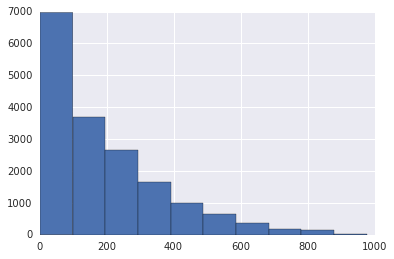

In [8]:
plt.hist(bike_rentals['cnt'])

In [9]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A computer will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

I will write a function that labels hours as:
- 1 if the hour is from 6 to 12 (morning)
- 2 if the hour is from 12 to 18 (afternoon)
- 3 if the hour is from 18 to 24 (evening)
- 4 if the hour is from 0 to 6 (night)

In [12]:
def assign_label(hour):
    if hour >= 0 and hour <= 6:
        return 4
    elif hour < 12:
        return 1
    elif hour < 18:
        return 2
    elif hour <= 24:
        return 3
    else:
        return ValueError('Hour is not in range (0,24)')
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4


I will use the root mean squared error metric to evaluate error.

Now I will assign train the ML algorithm with 80% of the data, and test it with 20% of the data.

In [13]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Linear Regression

I will now apply linear regression to the data. I will ignore the columns 'casual' and 'registered' because they are used to calculate cnt, as well as 'dteday'.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

cols = list(train.columns)
remove_cols = ['cnt', 'casual', 'dteday', 'registered']
cols = [c for c in cols if c not in remove_cols]
target = 'cnt'

model = LinearRegression()
model.fit(train[cols], train[target])
predictions = model.predict(test[cols])
rmse = mean_squared_error(predictions, test[target])**(1/2)
print('Root mean squared error: ', rmse)

Root mean squared error:  124.24090399116524


The error is very high, which may be due to the fact that the data has a few extremely high rental counts. With RMSE, larger errors are penalized more, which leads to a higher total error.

### Decision Tree

I will now apply a decision tree algorithm, which will hopefully have less error. I will also vary the min_samples_leaf to see if it changes the error.

In [59]:
from sklearn.tree import DecisionTreeRegressor

def dt_rmse(msl):
    model = DecisionTreeRegressor(min_samples_leaf=msl, random_state=1)
    model.fit(train[cols], train[target])
    predictions = model.predict(test[cols])
    rmse = mean_squared_error(predictions, test[target])**(1/2)
    return rmse
    
rmse_list = []
for i in range(2,20):
    rmse_list.append(dt_rmse(i))

min_index = rmse_list.index(min(rmse_list))
min_rmse = rmse_list[min_index]
print('Min RMSE of {} occured with min_sample_leaf of {}'.format(min_rmse, min_index + 2))

Min RMSE of 48.924020561243864 occured with min_sample_leaf of 9


Using a decision tree, we were able to get a root mean squared error of approx. 48.9, which is approx. 60% less than the RMSE value we obtained using linear regression.

### Random Forests

I will now apply the random forest algorithm, which improves the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so I will vary some parameters to find the values that produce the least error.

In [67]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 1)
model.fit(train[cols], train[target])
predictions = model.predict(test[cols])
rmse = mean_squared_error(predictions, test[target])**(1/2)

print('RMSE: ', rmse)

RMSE:  42.30719588155405


By using the default RandomForestRegressor, we were able to further reduce the RMSE down to approx. 42.3.

I will now experiment with various values of n_estimators and min_sample_leaf to see if we can get a lower RMSE.


In [81]:
def random_forests(n_est, msl):
    model = RandomForestRegressor(n_estimators = n_est, min_samples_leaf = msl, random_state=1)
    model.fit(train[cols], train[target])
    predictions = model.predict(test[cols])
    rmse = mean_squared_error(predictions, test[target])**(1/2)
    
    print('RMSE: ', rmse)
    print('n_estimators: ', n_est)
    print('min_samples_leaf: ', msl)
    print('\n')
    return rmse

random_forests(200,1)

RMSE:  40.35136016975025
n_estimators:  200
min_samples_leaf:  1




40.35136016975025

In [82]:
random_forests(200,6)

RMSE:  42.36554736831438
n_estimators:  200
min_samples_leaf:  6




42.36554736831438

In [83]:
random_forests(100,6)

RMSE:  42.47056811140465
n_estimators:  100
min_samples_leaf:  6




42.47056811140465

It appears that increasing n_estimators decreases rmse, while increasing min_samples_leaf decreases rmse. This makes sense, as increasing n_estimators increases the number of decision trees in the random_forest, and it gets a more accurate prediction. Increasing min_sample_leaf decreases accuracy because the trees are less accurate. This is in contrast to the individual decision tree, where increasing n_estimators made it more accurate, because with random forests we have many different decision trees that it averages.

Let's find the optimal number of trees to create by varying n_estimators.

In [86]:
min_rmse = 100000
min_ne = 0

for n_estimators in range(100, 351, 50):
        rmse = random_forests(n_est = n_estimators, msl=1)
        if rmse < min_rmse:
            min_rmse = rmse
            min_ne = n_estimators

print('__' * 10)
print('Min RMSE: ', min_rmse)
print('Optimal n_estimators: ', min_ne)

RMSE:  40.28048146395198
n_estimators:  100
min_samples_leaf:  1


RMSE:  40.33009469747278
n_estimators:  150
min_samples_leaf:  1


RMSE:  40.35136016975025
n_estimators:  200
min_samples_leaf:  1


RMSE:  40.17376895461032
n_estimators:  250
min_samples_leaf:  1


RMSE:  40.19247649611085
n_estimators:  300
min_samples_leaf:  1


RMSE:  40.2183984196327
n_estimators:  350
min_samples_leaf:  1


____________________
Min RMSE:  40.17376895461032
Optimal n_estimators:  250


It appears that the optimal number of estimators is somewhere around 250.
We could iterate from n_estimators = 201 to 299, however this would take a very long time and we likely wouldn't get an RMSE substantially lower than 40.173.